# DDPG (Deep Deterministic Policy Gradient)

Until now, we applied [policy gradient (on-policy)](./02-policy-gradient.ipynb) in order to handle continuos spaces. (This method then leads to modern [PPO algorithm](./04-ppo.ipynb).)<br>
DDPG (Deep Deterministic Policy Gradient) also apply policy gradient and use Actor-Critic architecture, but it's "deterministic" and **off-policy**, unlike policy gradient discussed in above.

After I have introduced DDPG in this notebook, next I'll proceed to more advanced off-policy algorithm, SAC.

*(back to [index](https://github.com/tsmatz/reinforcement-learning-tutorials/))*

In [ ]:
!pip install numpy tensorflow==2.4 matplotlib

In [1]:
import random
import numpy as np
import tensorflow as tf

Because DDPG cannot operate discrete action space, and here we then use custom CartPole implementation for continuous action space.<br>
The shape of action space in this example is ```Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)```.

In [2]:
from util.cartpole import CartPole
env = CartPole()

We will start with the following equation (Bellman equation) discussed in [Q-Learning](./01-q-learning.ipynb) :

$$ Q^{*}(s_t,a_t) = r_t + \gamma \max_a{Q(s_{t+1},a)} \;\;\;\;\;\; (1)$$

where $ Q^{*} $ means the optimal $ Q $ value.

Now we consider Q-network $ Q_{\phi} $ where $\phi$ is parameters.<br>
To optimize the equation (1), we should find $\phi$ to minimize the following loss $L$ for tuples $ (s_t, a_t, r_t, s_{t+1}, d_t) $.

$$ L = E\left[ \left( Q_{\phi}(s_t, a_t) - \left( r_t + \gamma (d_t - 1) \max_a{Q_{\phi}(s_{t+1},a)} \right) \right)^2 \right] \;\;\;\;\;\; (2)$$

where $d_t = 1$ if the episode is done, and $0$ otherwise.

To make the above maximization $\max_a Q_{\phi}(s_{t+1}, a)$ work in continuous action space, we introduce the action policy $\mu_{\theta}(s)$, with which we'll find $\theta$ to maximize $ Q_{\phi}(s, \mu_{\theta}(s)) $.<br>
The equation (2) will then be written as follows.

$$ L = E\left[ \left( Q_{\phi}(s_t, a_t) - \left( r_t + \gamma (d_t - 1) Q_{\phi}(s_{t+1},\mu_{\theta}(s_{t+1})) \right) \right)^2 \right] \;\;\;\;\;\; (3) $$

> Note : As you will find, this is again based on [Actor-Critic method](./03-actor-critic.ipynb) which separates policy and value evaluation in algorithm.

Please take care for the difference between this policy $\mu_{\theta}(s)$ and a policy used in [on-policy](./02-policy-gradient.ipynb). Here $\mu_{\theta}(s)$ is deterministic and it doesn't care how the actions are selected, unlike $ P(a | \pi_\theta (s)) $ in on-policy methods. (This is because DDPG is "deterministic" and off-policy.)

To make the minimization (2) stable, we also introduce the separated parameters $\phi^{\prime}$ and $\theta^{\prime}$ (called **target**) as follows.

$$ L = E\left[ \left( Q_{\phi}(s_t, a_t) - \left( r_t + \gamma (d_t - 1) Q_{{\phi}^{\prime}}(s_{t+1},\mu_{\theta^{\prime}}(s_{t+1})) \right) \right)^2 \right] \;\;\;\;\;\; (4) $$

And these parameters are delayed with coefficient parameter (hyper-parameter) $ \tau $ (which is near 0) after each training.

$ \phi^{\prime} = \tau \phi + (1-\tau) \phi^{\prime} $

$ \theta^{\prime} = \tau \theta + (1-\tau) \theta^{\prime} $

To summarize algorithm :

- Collect tuples $ (s_t, a_t, r_t, s_{t+1}, d_t) $
- Optimize $ \phi $ to minimize $L$ in (4)
- Optimize $ \theta $ to maximize $Q_{\phi}(s, \mu_{\theta}(s))$
- Update target parameters as follows
    - $ \phi^{\prime} = \tau \phi + (1-\tau) \phi^{\prime} $
    - $ \theta^{\prime} = \tau \theta + (1-\tau) \theta^{\prime} $

(1) Q-network

In [3]:
# origin Q net (Q_phi)
s_input_critic = tf.keras.layers.Input(shape=(4, ))
a_input_critic = tf.keras.layers.Input(shape=(1, ))
last_critic = tf.keras.layers.Concatenate()([s_input_critic, a_input_critic])
last_critic = tf.keras.layers.Dense(64,activation='relu')(last_critic)
output_critic = tf.keras.layers.Dense(1,activation=None)(last_critic)
q_model = tf.keras.Model([s_input_critic, a_input_critic], output_critic)

# target Q net (Q_phi')
s_input_critic_tg = tf.keras.layers.Input(shape=(4, ))
a_input_critic_tg = tf.keras.layers.Input(shape=(1, ))
last_critic_tg = tf.keras.layers.Concatenate()([s_input_critic_tg, a_input_critic_tg])
last_critic_tg = tf.keras.layers.Dense(64,activation='relu')(last_critic_tg)
output_critic_tg = tf.keras.layers.Dense(1,activation=None)(last_critic_tg)
q_tg_model = tf.keras.Model([s_input_critic_tg, a_input_critic_tg], output_critic_tg)

(2) Policy network ($\mu$)

In [4]:
# origin policy net (mu_theta)
s_input_actor = tf.keras.layers.Input(shape=(4, ))
last_actor = tf.keras.layers.Dense(64,activation='relu')(s_input_actor)
output_actor = tf.keras.layers.Dense(1,activation='tanh')(last_actor)
mu_model = tf.keras.Model([s_input_actor], output_actor)

# target policy net (mu_theta')
s_input_actor_tg = tf.keras.layers.Input(shape=(4, ))
last_actor_tg = tf.keras.layers.Dense(64,activation='relu')(s_input_actor_tg)
output_actor_tg = tf.keras.layers.Dense(1,activation='tanh')(last_actor_tg)
mu_tg_model = tf.keras.Model([s_input_actor_tg], output_actor_tg)

(3) Function to optimize network parameters $\phi, \theta$

In [5]:
gamma = 0.99
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

def optimize(states, actions, rewards, next_states, dones):
    states_t      = tf.convert_to_tensor(states)
    actions_t     = tf.convert_to_tensor(actions)
    rewards_t     = tf.convert_to_tensor(rewards)
    next_states_t = tf.convert_to_tensor(next_states)
    dones_t       = tf.convert_to_tensor(dones)

    # critic loss
    with tf.GradientTape() as tape:
        q_t = q_model([states_t, actions_t], training=True)
        next_mu_tg_t = mu_tg_model([next_states_t], training=True)
        next_q_tg_t = q_tg_model([next_states_t, next_mu_tg_t], training=True)
        q_tg_t = rewards_t + gamma * (1.0 - dones_t) * next_q_tg_t
        critic_loss_suqares_t = tf.math.square(q_t - q_tg_t)
        critic_loss_t = tf.reduce_mean(critic_loss_suqares_t)

    # optimize critic
    grad_q = tape.gradient(
        critic_loss_t,
        q_model.trainable_variables)
    opt.apply_gradients(zip(grad_q, q_model.trainable_variables))

    # actor loss
    with tf.GradientTape() as tape:
        mu_t = mu_model([states_t], training=True)
        q_t_max = q_model([states_t, mu_t], training=True)
        actor_loss_t = -tf.reduce_mean(q_t_max)

    # optimize actor
    grad_a = tape.gradient(
        actor_loss_t,
        mu_model.trainable_variables)
    opt.apply_gradients(zip(grad_a, mu_model.trainable_variables))

(4) Function to update target parameters $\phi^{\prime}, \theta^{\prime}$

In [6]:
tau = 0.002

def update_target():
    for var, var_target in zip(q_model.variables, q_tg_model.variables):
        var_target.assign(tau * var + (1.0 - tau) * var_target)
    for var, var_target in zip(mu_model.variables, mu_tg_model.variables):
        var_target.assign(tau * var + (1.0 - tau) * var_target)

(5) Replay buffer

In on-policy architecture, we fed the sequential samples (trajectory) for each training batch. (See [here](./02-policy-gradient.ipynb).)<br>
However, to prevent from learning only for recent experiences, we store the past experience of tuples $ (s_t, a_t, r_t, s_{t+1}, d_t) $ in buffer (called "replay buffer") and pick up the randomized samples for batch training in DDPG.

In [7]:
class replayBuffer:
    def __init__(self, buffer_size: int):
        self.buffer_size = buffer_size
        self.buffer = []
        self._next_idx = 0

    def add(self, item):
        if len(self.buffer) > self._next_idx:
            self.buffer[self._next_idx] = item
        else:
            self.buffer.append(item)
        if self._next_idx == self.buffer_size - 1:
            self._next_idx = 0
        else:
            self._next_idx = self._next_idx + 1

    def sample(self, batch_size):
        indices = [random.randint(0, len(self.buffer) - 1) for _ in range(batch_size)]
        states   = [self.buffer[i][0] for i in indices]
        actions  = [[self.buffer[i][1]] for i in indices]
        rewards  = [[self.buffer[i][2]] for i in indices]
        n_states = [self.buffer[i][3] for i in indices]
        dones    = [[self.buffer[i][4]] for i in indices]
        return states, actions, rewards, n_states, dones

    def length(self):
        return len(self.buffer)

buffer = replayBuffer(20000)

(6) Noise for exploration

As I mentioned above, the policy $\mu_{\theta}(s)$ is deterministic and it doesn't care how the actions are selected. In order for this reason, the noise will be added for exploration to pick up samples in episode's trials. (If not, this will stuck in the same values forever.)<br>
In DDPG, the following noise (so called [Ornstein-Uhlenbeck](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process) noise) is used.

In [8]:
"""
Ornstein-Uhlenbeck noise implemented by OpenAI
Copied from https://github.com/openai/baselines/blob/master/baselines/ddpg/noise.py
"""
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

ou_action_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(1), sigma=np.ones(1) * 0.05)

# pick up action with Ornstein-Uhlenbeck noise
def pick_sample(s):
    action_det = mu_model(tf.cast(np.array([s]), tf.float32))
    action_det = tf.squeeze(action_det, axis=1)
    noise = ou_action_noise()
    action = action_det.numpy() + noise
    action = np.clip(action, -1.0, 1.0)
    return float(action.item())

(7) Now let's put it all together !

In [9]:
batch_size = 250

reward_records = []
for i in range(1500):
    # Run episode till done
    s = env.reset()
    done = False
    cum_reward = 0
    while not done:
        a = pick_sample(s)
        s_next, r, done, _ = env.step(a)
        buffer.add([s, a, r, s_next, float(done)])
        cum_reward += r
        if buffer.length() >= batch_size:
            states, actions, rewards, n_states, dones = buffer.sample(batch_size)
            optimize(states, actions, rewards, n_states, dones)
            update_target()
        s = s_next

    # Output total rewards in episode (max 200)
    print("Run episode{} with rewards {}".format(i, cum_reward), end="\r")
    reward_records.append(cum_reward)

    # stop if reward mean > 195.0
    reward_records_np = np.array(reward_records)
    if np.average(reward_records_np[-50:]) > 195.0:
        break

print("\nDone")

Run episode1309 with rewards 200.0
Done


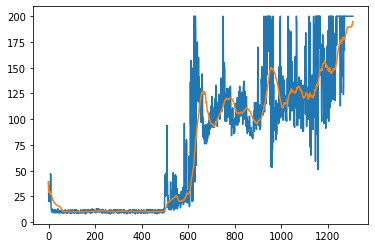

In [10]:
import matplotlib.pyplot as plt
# Generate recent 50 interval average
reward_records_np = np.array(reward_records)
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records_np[:idx+1]
    else:
        avg_list = reward_records_np[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records)
plt.plot(average_reward)

## [Optional] Clipped double-Q learning (Twin-Q)

In advanced algorithms, such as TD3 (Twin Delayed DDPG), 2 Q-networks - $ Q_{\phi_1}(s, a), Q_{\phi_2}(s, a) $ - and corresponding 2 target networks - $ Q_{\phi_1^{\prime}}(s, a), Q_{\phi_2^{\prime}}(s, a) $ - are used to optimize.<br>
Potentially this mechanism will mitigate the risk for overestimation in Q-function

In this double-Q algorithms, we optimize parameters as follows :

- Optimize $ \phi_1 $ to minimize $ E\left[ \left( Q_{\phi_1}(s_t, a_t) - \left( r_t + \gamma (d_t - 1) \min_{i=1,2} Q_{{\phi_i}^{\prime}}(s_{t+1},\mu_{\theta^{\prime}}(s_{t+1})) \right) \right)^2 \right] $
- Optimize $ \phi_2 $ to minimize $ E\left[ \left( Q_{\phi_2}(s_t, a_t) - \left( r_t + \gamma (d_t - 1) \min_{i=1,2} Q_{{\phi_i}^{\prime}}(s_{t+1},\mu_{\theta^{\prime}}(s_{t+1})) \right) \right)^2 \right] $
- Optimize $ \theta $ to maximize $Q_{\phi_1}(s, \mu_{\theta}(s))$

And update target parameters as :

- $ \phi_1^{\prime} = \tau \phi_1 + (1-\tau) \phi_1^{\prime} $
- $ \phi_2^{\prime} = \tau \phi_2 + (1-\tau) \phi_2^{\prime} $
- $ \theta^{\prime} = \tau \theta + (1-\tau) \theta^{\prime} $

(1) First, regenerate Q-network and policy network as follows.

In [11]:
# origin Q net 1 (Q_phi1)
s_input_critic1 = tf.keras.layers.Input(shape=(4, ))
a_input_critic1 = tf.keras.layers.Input(shape=(1, ))
last_critic1 = tf.keras.layers.Concatenate()([s_input_critic1, a_input_critic1])
last_critic1 = tf.keras.layers.Dense(64,activation='relu')(last_critic1)
output_critic1 = tf.keras.layers.Dense(1,activation=None)(last_critic1)
q_model1 = tf.keras.Model([s_input_critic1, a_input_critic1], output_critic1)

# origin Q net 2 (Q_phi2)
s_input_critic2 = tf.keras.layers.Input(shape=(4, ))
a_input_critic2 = tf.keras.layers.Input(shape=(1, ))
last_critic2 = tf.keras.layers.Concatenate()([s_input_critic2, a_input_critic2])
last_critic2 = tf.keras.layers.Dense(64,activation='relu')(last_critic2)
output_critic2 = tf.keras.layers.Dense(1,activation=None)(last_critic2)
q_model2 = tf.keras.Model([s_input_critic2, a_input_critic2], output_critic2)

# target Q net 1 (Q_phi1')
s_input_critic_tg1 = tf.keras.layers.Input(shape=(4, ))
a_input_critic_tg1 = tf.keras.layers.Input(shape=(1, ))
last_critic_tg1 = tf.keras.layers.Concatenate()([s_input_critic_tg1, a_input_critic_tg1])
last_critic_tg1 = tf.keras.layers.Dense(64,activation='relu')(last_critic_tg1)
output_critic_tg1 = tf.keras.layers.Dense(1,activation=None)(last_critic_tg1)
q_tg_model1 = tf.keras.Model([s_input_critic_tg1, a_input_critic_tg1], output_critic_tg1)

# target Q net 2 (Q_phi2')
s_input_critic_tg2 = tf.keras.layers.Input(shape=(4, ))
a_input_critic_tg2 = tf.keras.layers.Input(shape=(1, ))
last_critic_tg2 = tf.keras.layers.Concatenate()([s_input_critic_tg2, a_input_critic_tg2])
last_critic_tg2 = tf.keras.layers.Dense(64,activation='relu')(last_critic_tg2)
output_critic_tg2 = tf.keras.layers.Dense(1,activation=None)(last_critic_tg2)
q_tg_model2 = tf.keras.Model([s_input_critic_tg2, a_input_critic_tg2], output_critic_tg2)

In [12]:
# origin policy net (mu_theta)
s_input_actor = tf.keras.layers.Input(shape=(4, ))
last_actor = tf.keras.layers.Dense(64,activation='relu')(s_input_actor)
output_actor = tf.keras.layers.Dense(1,activation='tanh')(last_actor)
mu_model = tf.keras.Model([s_input_actor], output_actor)

# target policy net (mu_theta')
s_input_actor_tg = tf.keras.layers.Input(shape=(4, ))
last_actor_tg = tf.keras.layers.Dense(64,activation='relu')(s_input_actor_tg)
output_actor_tg = tf.keras.layers.Dense(1,activation='tanh')(last_actor_tg)
mu_tg_model = tf.keras.Model([s_input_actor_tg], output_actor_tg)

(2) Regenerate optimize function.

In [13]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

def optimize(states, actions, rewards, next_states, dones):
    states_t      = tf.convert_to_tensor(states)
    actions_t     = tf.convert_to_tensor(actions)
    rewards_t     = tf.convert_to_tensor(rewards)
    next_states_t = tf.convert_to_tensor(next_states)
    dones_t       = tf.convert_to_tensor(dones)

    # critic loss (Q-network 1)
    with tf.GradientTape() as tape:
        next_mu_tg_t = mu_tg_model([next_states_t], training=True)
        next_q_tg_t1 = q_tg_model1([next_states_t, next_mu_tg_t], training=True)
        next_q_tg_t2 = q_tg_model2([next_states_t, next_mu_tg_t], training=True)
        next_q_tg_t = tf.minimum(next_q_tg_t1, next_q_tg_t2)
        q_tg_t = rewards_t + gamma * (1.0 - dones_t) * next_q_tg_t

        q_t1 = q_model1([states_t, actions_t], training=True)
        critic_loss_suqares_t1 = tf.math.square(q_t1 - q_tg_t)
        critic_loss_t1 = tf.reduce_mean(critic_loss_suqares_t1)

    # optimize critic (Q-network 1)
    grad_q1 = tape.gradient(
        critic_loss_t1,
        q_model1.trainable_variables)
    opt.apply_gradients(zip(grad_q1, q_model1.trainable_variables))

    # critic loss (Q-network 2)
    with tf.GradientTape() as tape:
        next_mu_tg_t = mu_tg_model([next_states_t], training=True)
        next_q_tg_t1 = q_tg_model1([next_states_t, next_mu_tg_t], training=True)
        next_q_tg_t2 = q_tg_model2([next_states_t, next_mu_tg_t], training=True)
        next_q_tg_t = tf.minimum(next_q_tg_t1, next_q_tg_t2)
        q_tg_t = rewards_t + gamma * (1.0 - dones_t) * next_q_tg_t

        q_t2 = q_model2([states_t, actions_t], training=True)
        critic_loss_suqares_t2 = tf.math.square(q_t2 - q_tg_t)
        critic_loss_t2 = tf.reduce_mean(critic_loss_suqares_t2)

    # optimize critic (Q-network 2)
    grad_q2 = tape.gradient(
        critic_loss_t2,
        q_model2.trainable_variables)
    opt.apply_gradients(zip(grad_q2, q_model2.trainable_variables))

    # actor loss
    with tf.GradientTape() as tape:
        mu_t = mu_model([states_t], training=True)
        q_t_max = q_model1([states_t, mu_t], training=True)
        actor_loss_t = -tf.reduce_mean(q_t_max)

    # optimize actor
    grad_a = tape.gradient(
        actor_loss_t,
        mu_model.trainable_variables)
    opt.apply_gradients(zip(grad_a, mu_model.trainable_variables))

(3) Regenerate update target's params function.

In [14]:
def update_target():
    for var, var_target in zip(q_model1.variables, q_tg_model1.variables):
        var_target.assign(tau * var + (1.0 - tau) * var_target)
    for var, var_target in zip(q_model2.variables, q_tg_model2.variables):
        var_target.assign(tau * var + (1.0 - tau) * var_target)
    for var, var_target in zip(mu_model.variables, mu_tg_model.variables):
        var_target.assign(tau * var + (1.0 - tau) * var_target)

(4) Let's start training again !

In [15]:
# reset noise
ou_action_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(1), sigma=np.ones(1) * 0.05)

# reset buffer
buffer = replayBuffer(50000)

# start training
batch_size = 250
reward_records = []
for i in range(5000):
    # Run episode till done
    s = env.reset()
    done = False
    cum_reward = 0
    while not done:
        a = pick_sample(s)
        s_next, r, done, _ = env.step(a)
        buffer.add([s, a, r, s_next, float(done)])
        cum_reward += r
        if buffer.length() >= batch_size:
            states, actions, rewards, n_states, dones = buffer.sample(batch_size)
            optimize(states, actions, rewards, n_states, dones)
            update_target()
        s = s_next

    # Output total rewards in episode (max 200)
    print("Run episode{} with rewards {}".format(i, cum_reward), end="\r")
    reward_records.append(cum_reward)

    # stop if reward mean > 195.0
    reward_records_np = np.array(reward_records)
    if np.average(reward_records_np[-50:]) > 195.0:
        break

print("\nDone")

Run episode1263 with rewards 200.0
Done


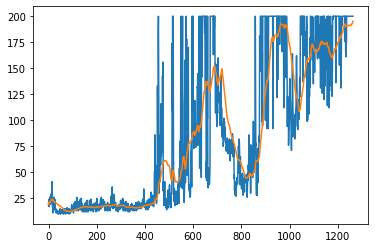

In [16]:
import matplotlib.pyplot as plt
# Generate recent 50 interval average
reward_records_np = np.array(reward_records)
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records_np[:idx+1]
    else:
        avg_list = reward_records_np[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records)
plt.plot(average_reward)